In [1]:
!pip install --force-reinstall --no-cache-dir "datasets==2.19.1" "pyarrow==14.0.2"
!pip install "numpy<2.0" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 220.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 255.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 150.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 266.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 287.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 230.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 288.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-11-24 22:25:56.259945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764023156.497695      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764023156.565478      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
import keras
print("keras:", keras.__version__)
print("tensorflow:", tf.__version__)

keras: 3.8.0
tensorflow: 2.18.0


In [4]:
!pip install --upgrade keras-hub==0.23.0
import keras_hub
print(keras_hub.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.18.1
    Uninstalling keras-hub-0.18.1:
      Successfully uninstalled keras-hub-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
keras-nlp 0.18.1 requires keras-hub==0.18

In [5]:
dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets", split="train")

ai_imgs = [ex for ex in dataset if ex["label"] == 0]
real_imgs = [ex for ex in dataset if ex["label"] == 1]

num_samples = min(len(ai_imgs), len(real_imgs)) // 2
ai_subset = random.sample(ai_imgs, num_samples)
real_subset = random.sample(real_imgs, num_samples)

subset = ai_subset + real_subset
random.shuffle(subset)

print(f"Usando {len(subset)} imágenes balanceadas")


Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

Usando 71536 imágenes balanceadas


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen_augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0, # Ajustado: channel shift suele ser valor absoluto, no %
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='reflect'
)

def process_image(img):
    # Corrección: Manejo seguro de transparencia
    if img.mode in ("P", "RGBA"):
        img = img.convert("RGBA")
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    else:
        img = img.convert("RGB")
    return img.resize(IMG_SIZE)

from tensorflow.keras.utils import to_categorical

def data_generator(samples, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    num_samples = len(samples)
    while True:
        if shuffle:
            random.shuffle(samples)

        for i in range(0, num_samples, batch_size):
            batch = samples[i:i+batch_size]
            images, labels = [], []

            for ex in batch:
                try:
                    img = process_image(ex["image"])
                    img_array = np.array(img, dtype="float32")

                    if augment:
                        transform_params = datagen_augmentor.get_random_transform(img_array.shape)
                        img_array = datagen_augmentor.apply_transform(img_array, transform_params)

                    images.append(img_array)
                    labels.append(ex["label"])

                except Exception as e:
                    print(f"Error: {e}")
                    continue

            if len(images) > 0:
                X_batch = np.array(images)

                y_batch = to_categorical(np.array(labels), num_classes=2)

                yield X_batch, y_batch

In [7]:
from sklearn.model_selection import train_test_split

train_subset, test_subset = train_test_split(
    subset,
    test_size=0.15,
    stratify=[s["label"] for s in subset],
    random_state=42
)


train_subset, val_subset = train_test_split(
    train_subset,
    test_size=0.2,
    stratify=[s["label"] for s in train_subset],
    random_state=42
)


train_gen = data_generator(train_subset, batch_size=BATCH_SIZE, shuffle=True, augment=True)
val_gen = data_generator(val_subset, batch_size=BATCH_SIZE, shuffle=False, augment=False)
test_gen = data_generator(test_subset, batch_size=BATCH_SIZE, shuffle=False, augment=False)

steps_per_epoch = len(train_subset) // BATCH_SIZE
val_steps = len(val_subset) // BATCH_SIZE
test_steps = len(test_subset) // BATCH_SIZE

In [8]:
PRESET_NAME = "vit_base_patch16_224_imagenet"
num_classes = 2

vit_backbone = keras_hub.models.ViTBackbone.from_preset(
    PRESET_NAME,
    load_weights=True
)
vit_backbone.trainable = False
inputs = keras.Input(shape=(224, 224,3))
x = vit_backbone(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation="gelu")(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary() 


I0000 00:00:1764023401.447818      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764023401.448542      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,897,346 (327.67 MB)

 Trainable params: 98,690 (385.51 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [9]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Inicializamos Precision y Recall internos
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        # Fórmula del F1 Score: 2 * (P * R) / (P + R)
        return 2 * ((p * r) / (p + r + 1e-7))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [10]:
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=opt,

    loss='categorical_crossentropy',

    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2, # Reducir LR al 20%
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history = model.fit(
    train_gen,  # Usamos tu generador, NO datagen.flow
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


I0000 00:00:1764023424.079027     188 service.cc:148] XLA service 0x7eb194023500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764023424.081011     188 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764023424.081035     188 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764023426.260630     188 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764023430.355233     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1013s 655ms/step - accuracy: 0.5607 - f1_score: 0.5607 - loss: 0.7058 - precision: 0.5607 - recall: 0.5607 - val_accuracy: 0.6573 - val_f1_score: 0.6573 - val_loss: 0.6254 - val_precision: 0.6573 - val_recall: 0.6573 - learning_rate: 1.0000e-04
Epoch 2/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1009s 661ms/step - accuracy: 0.6305 - f1_score: 0.6305 - loss: 0.6345 - precision: 0.6305 - recall: 0.6305 - val_accuracy: 0.6393 - val_f1_score: 0.6393 - val_loss: 0.6128 - val_precision: 0.6393 - val_recall: 0.6393 - learning_rate: 1.0000e-04
Epoch 3/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1000s 658ms/step - accuracy: 0.6476 - f1_score: 0.6476 - loss: 0.6171 - precision: 0.6476 - recall: 0.6476 - val_accuracy: 0.7029 - val_f1_score: 0.7029 - val_loss: 0.5741 - val_precision: 0.7029 - val_recall: 0.7029 - learning_rate: 1.0000e-04
Epoch 4/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 979s 644ms/step - accuracy: 0.6624 - f1_score: 0.6624 - loss: 0.5996 - precision: 0.6624 - recall: 0.6624 - 

In [11]:
model.save("vit_ai_vs_real.keras")


In [14]:
test_loss, test_acc, test_prec, test_rec, test_f1 = model.evaluate(
    test_gen,
    steps=test_steps,
    verbose=1
)

print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

335/335 ━━━━━━━━━━━━━━━━━━━━ 155s 464ms/step - accuracy: 0.7396 - f1_score: 0.7396 - loss: 0.5177 - precision: 0.7396 - recall: 0.7396
Test loss     : 0.5215
Test accuracy : 0.7364
Test precision: 0.7364
Test recall   : 0.7364
Test F1-score : 0.7364


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for _ in range(test_steps):
    X_batch, y_batch = next(test_gen)     # y_batch es one-hot
    preds = model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Reporte por clase
print(classification_report(y_true, y_pred, target_names=["AI", "Real"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:\n", cm)

              precision    recall  f1-score   support

          AI       0.74      0.73      0.73      5351
        Real       0.73      0.74      0.74      5348

    accuracy                           0.74     10699
   macro avg       0.74      0.74      0.74     10699
weighted avg       0.74      0.74      0.74     10699

Matriz de confusión:
 [[3903 1448]
 [1373 3975]]


In [19]:
metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    F1Score(name='f1_score')
]


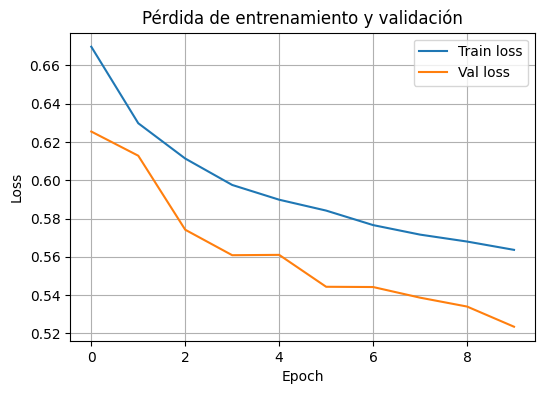

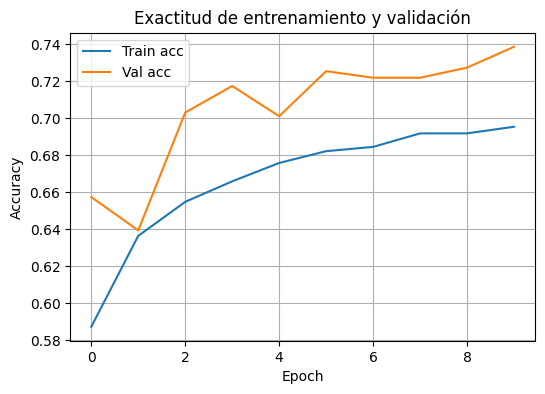

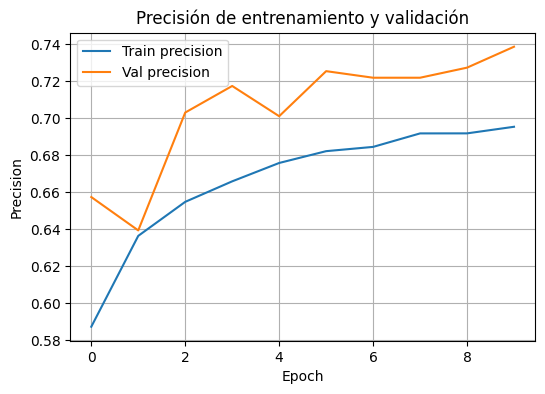

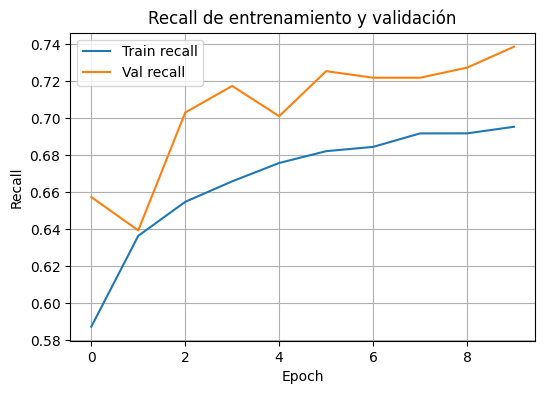

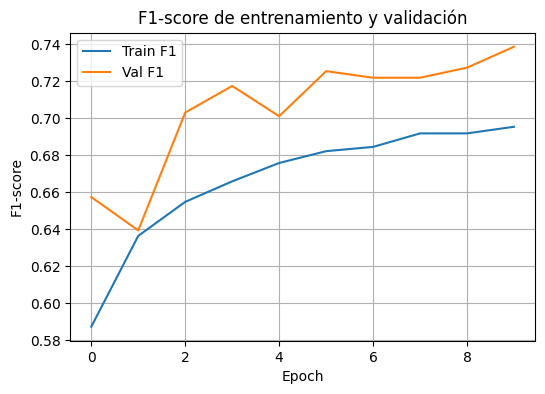

In [20]:
import matplotlib.pyplot as plt

# --- 2.1. Pérdida (loss) ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

# --- 2.2. Exactitud (accuracy) ---
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Exactitud de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

# --- 2.3. Precisión ---
plt.figure(figsize=(6,4))
plt.plot(history.history['precision'], label='Train precision')
plt.plot(history.history['val_precision'], label='Val precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precisión de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

# --- 2.4. Recall ---
plt.figure(figsize=(6,4))
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Val recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

# --- 2.5. F1-score ---
plt.figure(figsize=(6,4))
plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('F1-score de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()


AUC ROC en test: 0.8232


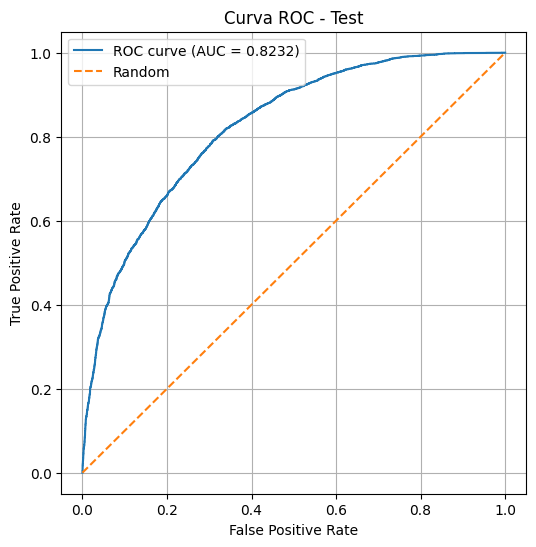

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Recogemos predicciones y etiquetas reales del generador de test
y_true = []
y_scores = []  # probabilidad de la clase 1 (Real) por ejemplo

for _ in range(test_steps):
    X_batch, y_batch = next(test_gen)         # y_batch es one-hot (N, 2)
    preds = model.predict(X_batch, verbose=0) # preds también (N, 2)

    # Guardamos únicamente la columna de la clase positiva (p(clase=1))
    y_true.extend(np.argmax(y_batch, axis=1))   # 0 = AI, 1 = Real
    y_scores.extend(preds[:, 1])                # probabilidad de "Real"

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# --- 2.1. AUC (ROC) ---
auc = roc_auc_score(y_true, y_scores)
print(f"AUC ROC en test: {auc:.4f}")

# --- 2.2. Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Test")
plt.legend()
plt.grid(True)
plt.show()


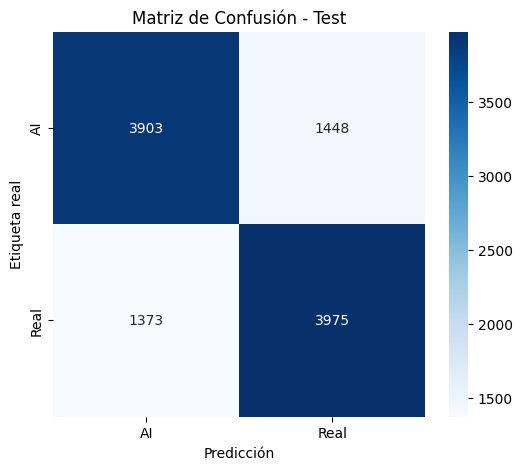

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

labels = ["AI", "Real"]  # tus clases: 0:AI, 1:Real

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - Test")
plt.show()
